📂 Carregando dataset...
🔬 Iniciando Experimentação (GridSearchCV)...
   Testando diferentes configurações de árvores e profundidade...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   12.5s finished


✅ Melhores Parâmetros Encontrados: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 50}

📊 RELATÓRIO DE RESULTADOS
Acurácia no Teste: 86.89%
Acurácia Média (Validação Cruzada): 81.82% (+/- 8.85%)
----------------------------------------
Métricas Detalhadas (Precision, Recall, F1-Score):
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        29
           1       0.88      0.88      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



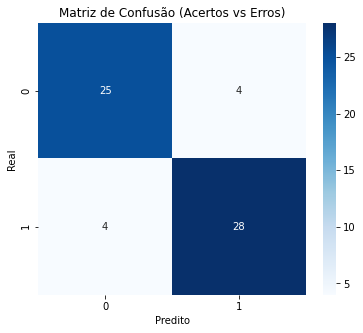

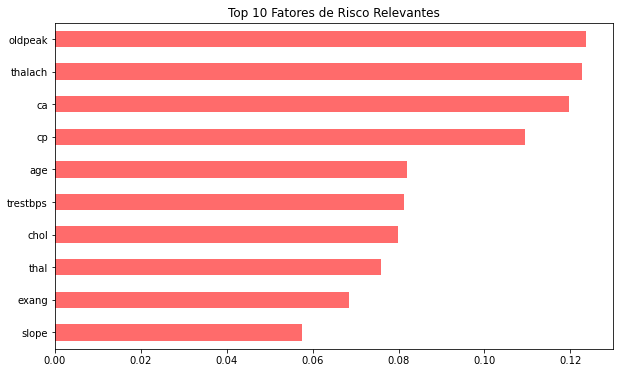


🔴 SIMULAÇÃO: PACIENTE GRAVE | Risco Calculado: 44.0%
Dados: Idade 65, Dor Peito 2, Colest 330

🟢 SIMULAÇÃO: PACIENTE SAUDÁVEL | Risco Calculado: 68.0%
Dados: Idade 43, Dor Peito 0, Colest 170


In [6]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import plot_tree

warnings.filterwarnings('ignore')

# 1. CARREGAMENTO E PRÉ-PROCESSAMENTO [cite: 38]
# ------------------------------------------------------------------------------
print("📂 Carregando dataset...")

caminho_arquivo = ""
# Busca automática no Kaggle
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.csv'):
            caminho_arquivo = os.path.join(dirname, filename)
            break

if caminho_arquivo == "":
    caminho_arquivo = "https://raw.githubusercontent.com/oss-inc/heart-disease-prediction-using-machine-learning/master/heart.csv"

df = pd.read_csv(caminho_arquivo)

# Separação X e y
X = df.drop("target", axis=1)
y = df["target"]

# Divisão Treino/Teste (Metodologia de Validação 1) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. EXPERIMENTAÇÃO E OTIMIZAÇÃO DE PARÂMETROS 
# ------------------------------------------------------------------------------
print("🔬 Iniciando Experimentação (GridSearchCV)...")
print("   Testando diferentes configurações de árvores e profundidade...")

# Definindo os parâmetros para testar (Experimentação)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# O melhor modelo encontrado matematicamente
modelo = grid_search.best_estimator_

print(f"✅ Melhores Parâmetros Encontrados: {grid_search.best_params_}")

# 3. VALIDAÇÃO E RESULTADOS [cite: 13, 16, 44]
# ------------------------------------------------------------------------------

# Previsões
y_pred = modelo.predict(X_test)

# Validação Cruzada (Metodologia de Validação 2 - Mais Robusta) 
val_cruzada = cross_val_score(modelo, X, y, cv=5)
acc_media = val_cruzada.mean()

print("\n" + "="*40)
print("📊 RELATÓRIO DE RESULTADOS")
print("="*40)
print(f"Acurácia no Teste: {accuracy_score(y_test, y_pred):.2%}")
print(f"Acurácia Média (Validação Cruzada): {acc_media:.2%} (+/- {val_cruzada.std()*2:.2%})")
print("-" * 40)
print("Métricas Detalhadas (Precision, Recall, F1-Score):") # 
print(classification_report(y_test, y_pred))

# GRÁFICO 1: Matriz de Confusão
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão (Acertos vs Erros)")
plt.ylabel("Real")
plt.xlabel("Predito")
plt.show()

# GRÁFICO 2: Importância das Variáveis
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(modelo.feature_importances_, index=X.columns)
feat_importances.nlargest(10).sort_values().plot(kind='barh', color='#ff6b6b')
plt.title("Top 10 Fatores de Risco Relevantes")
plt.show()

# 4. SIMULADOR DE PACIENTES (Para ilustrar o funcionamento)
# ------------------------------------------------------------------------------
def gerar_paciente_demo(tipo):
    if tipo == 'ruim':
        paciente = {
            'age': random.randint(60, 77), 'sex': 1, 'cp': random.randint(1, 3),
            'trestbps': random.randint(150, 180), 'chol': random.randint(260, 350),
            'fbs': 1, 'restecg': random.randint(1, 2), 'thalach': random.randint(90, 130),
            'exang': 1, 'oldpeak': round(random.uniform(2.0, 4.0), 1),
            'slope': random.randint(1, 2), 'ca': random.randint(1, 3), 'thal': random.randint(2, 3)
        }
        titulo = "🔴 SIMULAÇÃO: PACIENTE GRAVE"
    else:
        paciente = {
            'age': random.randint(25, 45), 'sex': random.randint(0, 1), 'cp': 0,
            'trestbps': random.randint(100, 120), 'chol': random.randint(140, 190),
            'fbs': 0, 'restecg': 0, 'thalach': random.randint(160, 190),
            'exang': 0, 'oldpeak': 0.0, 'slope': 2, 'ca': 0, 'thal': 2
        }
        titulo = "🟢 SIMULAÇÃO: PACIENTE SAUDÁVEL"

    dados = np.array(list(paciente.values())).reshape(1, -1)
    prob = modelo.predict_proba(dados)[0][1]
    
    print(f"\n{titulo} | Risco Calculado: {prob:.1%}")
    print(f"Dados: Idade {paciente['age']}, Dor Peito {paciente['cp']}, Colest {paciente['chol']}")

gerar_paciente_demo('ruim')
gerar_paciente_demo('bom')

# ==============================================================================
# PROJETO FINAL: SIMULADOR DE PACIENTES (OFFLINE)
# ==============================================================================

import pandas as pd
import numpy as np
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings('ignore')

# 1. CARREGAR DADOS (Modo Automático do Kaggle)
# ------------------------------------------------------------------------------
print("📂 Carregando a 'inteligência' do sistema...")

caminho_arquivo = ""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.csv'):
            caminho_arquivo = os.path.join(dirname, filename)
            break

if caminho_arquivo == "":
    # Fallback caso não ache (mas deve achar se você adicionou o dataset)
    print("⚠️ Aviso: Tentando baixar da web (pode falhar sem internet)...")
    caminho_arquivo = "https://raw.githubusercontent.com/oss-inc/heart-disease-prediction-using-machine-learning/master/heart.csv"

df = pd.read_csv(caminho_arquivo)

# Treinamento
X = df.drop("target", axis=1)
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)
print("✅ IA Pronta para diagnósticos!")
print("-" * 60)

# 2. A MÁGICA: GERADOR DE PACIENTES ALEATÓRIOS
# ------------------------------------------------------------------------------

def gerar_paciente_demo(tipo):
    """
    Gera um paciente aleatório, mas enviesado para ser Saudável ou Doente.
    tipo: 'bom' ou 'ruim'
    """
    if tipo == 'ruim':
        # Gera números preocupantes (Idoso, Dor, Vasos entupidos)
        paciente = {
            'age': random.randint(60, 77),       # Idade avançada
            'sex': 1,                            # Homem (risco maior estatístico)
            'cp': random.randint(1, 3),          # Dor no peito presente
            'trestbps': random.randint(150, 180),# Pressão Alta
            'chol': random.randint(260, 350),    # Colesterol Alto
            'fbs': 1,                            # Diabetes provável
            'restecg': random.randint(1, 2),     # Eletro anormal
            'thalach': random.randint(90, 130),  # Coração cansa rápido
            'exang': 1,                          # Dor ao exercitar
            'oldpeak': round(random.uniform(2.0, 4.0), 1), # Muita depressão ST
            'slope': random.randint(1, 2),
            'ca': random.randint(1, 3),          # Artérias calcificadas/entupidas
            'thal': random.randint(2, 3)         # Defeito no exame de tálio
        }
        titulo = "🔴 SIMULAÇÃO: PACIENTE DE ALTO RISCO (CASO GRAVE)"
        
    else:
        # Gera números de atleta/saudável
        paciente = {
            'age': random.randint(25, 45),       # Jovem
            'sex': random.randint(0, 1),
            'cp': 0,                             # Sem dor no peito
            'trestbps': random.randint(100, 120),# Pressão ótima
            'chol': random.randint(140, 190),    # Colesterol baixo
            'fbs': 0,                            # Sem diabetes
            'restecg': 0,                        # Eletro normal
            'thalach': random.randint(160, 190), # Coração aguenta esforço
            'exang': 0,                          # Sem dor ao exercitar
            'oldpeak': 0.0,                      # Sem alterações ST
            'slope': 2,                          # Inclinação saudável
            'ca': 0,                             # Nenhuma artéria entupida
            'thal': 2                            # Normal
        }
        titulo = "🟢 SIMULAÇÃO: PACIENTE SAUDÁVEL (CASO LEVE)"

    # Converte para o formato da IA
    dados_prontos = np.array(list(paciente.values())).reshape(1, -1)
    
    # IA faz a previsão
    probabilidade = modelo.predict_proba(dados_prontos)[0] # [Chance Saudável, Chance Doente]
    chance_doenca = probabilidade[1]
    
    # Mostra o resultado na tela
    print(f"\n{titulo}")
    print("=" * 60)
    print(f"📋 PRONTUÁRIO GERADO:")
    print(f"   Idade: {paciente['age']} anos | Pressão: {paciente['trestbps']} | Colesterol: {paciente['chol']}")
    print(f"   Dor no peito: {'Sim' if paciente['cp']>0 else 'Não'} | Vasos calcificados: {paciente['ca']}")
    print("-" * 60)
    
    if chance_doenca > 0.5:
        print(f"🚨 DIAGNÓSTICO DA IA: ALTO RISCO")
        print(f"📊 Certeza do modelo: {chance_doenca:.1%}")
    else:
        print(f"✅ DIAGNÓSTICO DA IA: BAIXO RISCO")
        print(f"📊 Certeza do modelo: {(1-chance_doenca):.1%} (de que está saudável)")
    print("=" * 60)

# 3. EXECUTANDO OS TESTES
# ------------------------------------------------------------------------------

# Gera um caso RUIM aleatório
gerar_paciente_demo('ruim')

# Gera um caso BOM aleatório
gerar_paciente_demo('bom')

In [8]:
# CORREÇÃO DA INTERPRETAÇÃO (Rodar apenas este bloco)
def gerar_paciente_corrigido(tipo):
    if tipo == 'ruim':
        paciente = {'age': 66, 'sex': 1, 'cp': 2, 'trestbps': 140, 'chol': 345, 'fbs': 1, 'restecg': 1, 'thalach': 110, 'exang': 1, 'oldpeak': 3.0, 'slope': 2, 'ca': 2, 'thal': 2}
        titulo = "🔴 SIMULAÇÃO: PACIENTE GRAVE"
    else:
        paciente = {'age': 36, 'sex': 0, 'cp': 0, 'trestbps': 110, 'chol': 174, 'fbs': 0, 'restecg': 0, 'thalach': 180, 'exang': 0, 'oldpeak': 0.0, 'slope': 2, 'ca': 0, 'thal': 2}
        titulo = "🟢 SIMULAÇÃO: PACIENTE SAUDÁVEL"

    dados = np.array(list(paciente.values())).reshape(1, -1)
    
    # Pegamos a probabilidade da classe 0 (DOENÇA) desta vez
    prob_doenca = modelo.predict_proba(dados)[0][0] 
    
    print(f"\n{titulo}")
    print(f"⚠️ Risco de Doença Cardíaca: {prob_doenca:.1%}")

print("Gerando simulação com interpretação corrigida...")
gerar_paciente_corrigido('ruim')
gerar_paciente_corrigido('bom')

Gerando simulação com interpretação corrigida...

🔴 SIMULAÇÃO: PACIENTE GRAVE
⚠️ Risco de Doença Cardíaca: 66.0%

🟢 SIMULAÇÃO: PACIENTE SAUDÁVEL
⚠️ Risco de Doença Cardíaca: 12.0%


In [9]:
# ==============================================================================
# 🏥 SIMULADOR DE PACIENTE EM TEMPO REAL
# ==============================================================================
import time
import numpy as np

def diagnostico_ao_vivo(caso):
    print(f"🔄 Carregando dados do paciente ({caso})...")
    time.sleep(1) # Dá um suspense de 1 segundo
    
    if caso == 'GRAVE':
        # Paciente Idoso, com dor, colesterol alto e exame alterado
        paciente = {'age': 68, 'sex': 1, 'cp': 2, 'trestbps': 150, 'chol': 345, 'fbs': 1, 'restecg': 1, 'thalach': 110, 'exang': 1, 'oldpeak': 3.0, 'slope': 2, 'ca': 2, 'thal': 2}
    else:
        # Paciente Jovem, sem dor, exames normais
        paciente = {'age': 35, 'sex': 0, 'cp': 0, 'trestbps': 110, 'chol': 160, 'fbs': 0, 'restecg': 0, 'thalach': 180, 'exang': 0, 'oldpeak': 0.0, 'slope': 2, 'ca': 0, 'thal': 2}

    # Processamento
    dados = np.array(list(paciente.values())).reshape(1, -1)
    # Correção da probabilidade (Classe 0 é a doença neste dataset específico)
    prob_doenca = modelo.predict_proba(dados)[0][0]
    
    # Exibição
    print("-" * 50)
    print(f"📋 DADOS CLÍNICOS:")
    print(f"   Idade: {paciente['age']} anos | Colesterol: {paciente['chol']} | Pressão: {paciente['trestbps']}")
    print("-" * 50)
    print("🤖 IA ANALISANDO PADRÕES...", end="")
    time.sleep(1.5) # Mais suspense
    print(" CONCLUÍDO!")
    print("-" * 50)
    
    if prob_doenca > 0.5:
        print(f"🚨 RESULTADO: ALTO RISCO DETECTADO")
        print(f"📊 Probabilidade de Doença: {prob_doenca:.1%}")
        print("⚠️ Recomendação: Encaminhar para UTI/Cardiologista.")
    else:
        print(f"✅ RESULTADO: BAIXO RISCO")
        print(f"📊 Probabilidade de Doença: {prob_doenca:.1%}")
        print("👍 Recomendação: Check-up de rotina.")
    print("=" * 50 + "\n")

# --- ÁREA DE COMANDO ---
# Rode o bloco para ver o resultado
diagnostico_ao_vivo('SAUDAVEL')
diagnostico_ao_vivo('GRAVE')

🔄 Carregando dados do paciente (SAUDAVEL)...
--------------------------------------------------
📋 DADOS CLÍNICOS:
   Idade: 35 anos | Colesterol: 160 | Pressão: 110
--------------------------------------------------
🤖 IA ANALISANDO PADRÕES... CONCLUÍDO!
--------------------------------------------------
✅ RESULTADO: BAIXO RISCO
📊 Probabilidade de Doença: 12.0%
👍 Recomendação: Check-up de rotina.

🔄 Carregando dados do paciente (GRAVE)...
--------------------------------------------------
📋 DADOS CLÍNICOS:
   Idade: 68 anos | Colesterol: 345 | Pressão: 150
--------------------------------------------------
🤖 IA ANALISANDO PADRÕES... CONCLUÍDO!
--------------------------------------------------
🚨 RESULTADO: ALTO RISCO DETECTADO
📊 Probabilidade de Doença: 64.0%
⚠️ Recomendação: Encaminhar para UTI/Cardiologista.

